<a href="https://colab.research.google.com/github/mylovepyd03/26-1-Lab-Intern/blob/main/CNN_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 19.1 MB/s eta 0:00:00


In [52]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- test code에서 label을 주지 않고 사진만 넣어서 예측하게 해보기

# CNN

In [54]:
import os
from PIL import Image
import json

class TicTacToeCellDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = []
        self.labels_paths = []

        # 1. 이미지 폴더에서 .jpg 파일만 가져오기
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)

            # 2. 파일 이름 규칙 수정: '06.jpg' -> '06_labels.json'
            file_number = os.path.splitext(image_file)[0] # '06' 추출
            label_filename = f"{file_number}_labels.json" # '06_labels.json' 생성
            label_path = os.path.join(label_dir, label_filename)

            # 3. 해당 라벨 파일이 진짜 있을 때만 리스트에 추가
            if os.path.exists(label_path):
                self.image_paths.append(image_path)
                self.labels_paths.append(label_path)

        print(f"✅ 매칭 성공: {len(self.image_paths)}개의 이미지와 라벨 짝을 찾았습니다!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.labels_paths[idx]

        image = Image.open(image_path).convert('RGB')

        with open(label_path, 'r') as f:
            label_data = json.load(f)

        # O, X, blank 매핑 (정수형 long 타입으로 변환)
        label_mapping = {'O': 0, 'X': 1, 'blank': 2}
        label_list = [label_mapping[label_data[f'cell_{i}']] for i in range(9)]
        label_tensor = torch.tensor(label_list, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label_tensor

위의 cnn code 설명하기
만들어두신거 class 정의 ,
__init__ : "문제랑 정답 짝궁 찾기
__len__ : "문제 수가 몇 개야?"
__getitem__ : "한 문제씩 꺼내오기" 이때 매핑 , 컴퓨터의 o,x blank 숫자로 변환하기
"이 클래스는 이미지 파일명에서 번호를 추출해 JSON 정답 파일과 1:1로 매칭해주며, 텍스트로 된 라벨 정보를 모델 학습이 가능한 숫자형 텐서(Tensor)로 변환해주는 역할을 합니다."

In [55]:
import torch.nn as nn
import torch.nn.functional as F

class TicTacToeCNN(nn.Module):
    def __init__(self):
        super(TicTacToeCNN, self).__init__()
        '''
        hint: convoluation layer, batch normalization, dropout, fully connected 사용
        '''
        # 여기에 코드 작성해주세요
        #
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #rgb이미지3, 출력채널=32,필터크기3x3 ,패딩: 이미지크기유지
        self.bn1 = nn.BatchNorm2d(32) #여기서 채널은 특징의 개수를 의미한다ㅣ.
        #conv2는 conv1의 출력을 입력으로 받는다.
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        #채널 각각을 정규화: 학습을 안정적으로 만들기 위한 장치

         # Dropout:특정 패턴에만 과하게 의존하는 과적합을 막기위한것
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        #fully connected:
        self.fc1 = nn.Linear(128 * 4 * 4, 128) #8192개를 128로 줄이겟다 여기오류있음 4*4로 바꾸거나 입력을 64로해야함
        self.fc2 = nn.Linear(128, 27)
         # 여기에 코드 작성해주세요  # O, X, blank (3 classes)

         #입력이 64여야함

    def forward(self, x):
        # 여기에 코드 작성해주세요
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Conv Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Conv Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)


        return x

convoluation layer, batch normalization, dropout, fully connected 사용
1) (3: 입력 채널입니다. 컬러 이미지(RGB)라 빨강, 초록, 파랑 3가지 색상 정보를 받는다는 뜻이에요.

32)출력 채널입니다. 32개의 서로 다른 필터(돋보기)를 써서 32가지의 특징(가로선, 세로선, 대각선 등)을 찾아내겠다는 의지입니다.

3) 필터의 크기입니다. 3×3 크기의 작은 창문으로 이미지를 훑겠다는 뜻
3단계로 레이어를 쌓았는데, 복잡한 정보를 세층으로 쌓았을때 틱텍토를 기하학적 형태로 정확히 인식할수 있을것 같아서,
출력채널은정보량이 크진않지만, 적당한 정보를 담게 출력채널을 32로 설정
뒤로 갈수록 채널수를 늘려서 깊은정보 보기.

2.

nn.BatchNorm2d(32): 32개 특징들을 골고루 정규화
즉 데이터 수준을 비슷하게 맞춰서 학습속도를 올린다.

3.
dropout+ 이미지 풀링
maxpool 이용하고 학습할때 50프로 꺼버리는 전략

4. 3번풀링, 4x4이려면 입력이 32 여야함
 fc레이어를 통해 단서들 하나로 연결하는 코드 fully connected
 특징채널 128개, 풀링후 사이즈 4*4

5.
2048개의 단서를 종합해서 128개의 핵심 단서로 압축
128개 단서를 보고 최종적으로 27개의 숫자를 출력 9칸마다 3가지상태

✅ 매칭 성공: 40개의 이미지와 라벨 짝을 찾았습니다!
Epoch [1/100], Loss: 1.2070
Epoch [2/100], Loss: 1.1101
Epoch [3/100], Loss: 0.9318
Epoch [4/100], Loss: 0.9355
Epoch [5/100], Loss: 0.8659
Epoch [6/100], Loss: 0.8458
Epoch [7/100], Loss: 0.7998
Epoch [8/100], Loss: 0.7366
Epoch [9/100], Loss: 0.7022
Epoch [10/100], Loss: 0.6429
Epoch [11/100], Loss: 0.6106
Epoch [12/100], Loss: 0.5468
Epoch [13/100], Loss: 0.5643
Epoch [14/100], Loss: 0.5780
Epoch [15/100], Loss: 0.4904
Epoch [16/100], Loss: 0.4845
Epoch [17/100], Loss: 0.4715
Epoch [18/100], Loss: 0.4279
Epoch [19/100], Loss: 0.4225
Epoch [20/100], Loss: 0.3855
Epoch [21/100], Loss: 0.4756
Epoch [22/100], Loss: 0.4019
Epoch [23/100], Loss: 0.3810
Epoch [24/100], Loss: 0.3770
Epoch [25/100], Loss: 0.3370
Epoch [26/100], Loss: 0.3366
Epoch [27/100], Loss: 0.3577
Epoch [28/100], Loss: 0.2881
Epoch [29/100], Loss: 0.3760
Epoch [30/100], Loss: 0.3589
Epoch [31/100], Loss: 0.4248
Epoch [32/100], Loss: 0.4316
Epoch [33/100], Loss: 0.3806
Epoch [34/100], Loss

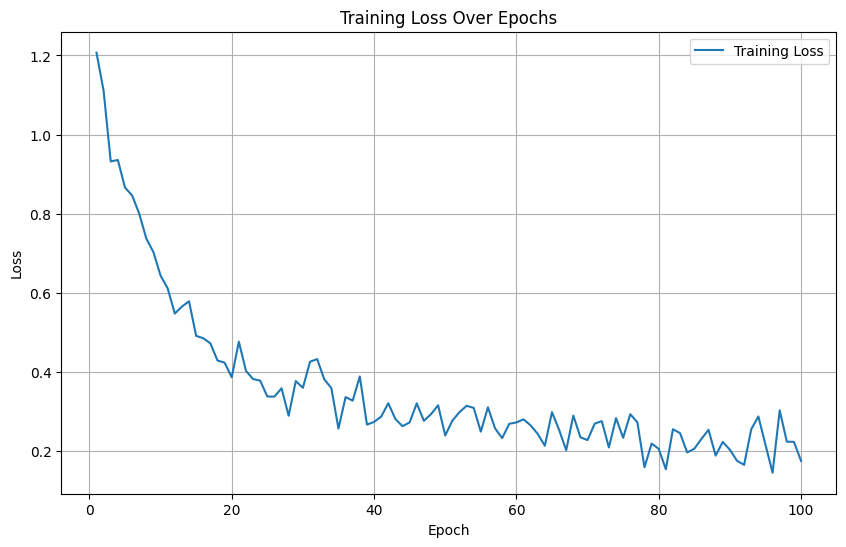

In [56]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt




# 데이터셋 및 데이터로더
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
     #사이즈 표준화, 폴딩 3번이므로 입력 무조건 32 들어와야하고 위에ㅔ 8대신 4로 바꿈

dataset = TicTacToeCellDataset(image_dir='/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_black', label_dir='/content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
#DataLoader: 데이터를 한꺼번에 다 넣으면 메모리가 터질 수 있으니, 8개씩(Batch) 잘라서 모델에게 전달하는 역할.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model = TicTacToeCNN().to(device)
criterion = nn.CrossEntropyLoss() # 모델의 예측값과 실제 정답 사이의 오차를 계산 /다중클래스 분류용 손실함수, 가장큰값이 모델이 고른 클래스 (27개)
optimizer = optim.Adam(model.parameters(), lr=0.001)#학습률 얼마나 크게할지

# 학습 루프
epochs =100  # 특별한 의미없이 10~30 사이)
loss_history = []

'''
hint: loss 그래프를 출력할 수 있도록 for loop가 돌아가기 전 loss_history=[] 만들기
      loss 출력값 확인해보는 것도 좋습니다.
'''
# 여기에 코드 작성해주세요
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        #데이터를 GPU로 이동

        optimizer.zero_grad() #기울기초기화 :이전루프의 계산값이 남아있지 않도록 비우기

        outputs = model(images)

        outputs = outputs.view(-1, 3)
        labels = labels.view(-1).long()
        loss = criterion(outputs, labels) #손실계산

        loss.backward()#역전파 (Backward): 어떤 가중치를 수정해야 오차가 줄어들지 미분 계산
        optimizer.step() #가중치 업데이트

        running_loss += loss.item() #오차기록
      #시각화 하기
    epoch_loss = running_loss / len(dataloader) #각 에포크마다 평균오차를 계산해 리스트에 저장하기.
    loss_history.append(epoch_loss) #(만들어둔 리스트에)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

훈련시키고,  결과 (손실함수를 그래프로 확인하는과정_)
데이터 로더 하고 배치사이즈 8로 정함
옵티마이저 - adam 으로하고 학습률 0.001로 설정,

학습루프 - 이때 gradient가 계속 더해지는걸 막기위해 optimizer_zero 넣음
역전파 이용해 가중치 다시 찾는과정

결과 그래프
그리는 코드들

loss history 통해서 에포크 수정해도. 학습진행 잘되도록 + 손실 기록위해 (그래프)

그리고 에포크 처음에 20으로했을때 정확률이 떨어져서 바꿈 보시면 손실함수값이 점점 작아짐을 알수있음.


## Validation ver.

✅ 매칭 성공: 3개의 데이터를 찾았습니다!
Epoch 1/100, Training Loss: 1.2253, Validation Loss: 1.0809
Epoch 2/100, Training Loss: 1.0430, Validation Loss: 1.0762
Epoch 3/100, Training Loss: 0.7799, Validation Loss: 1.0692
Epoch 4/100, Training Loss: 0.9787, Validation Loss: 1.0541
Epoch 5/100, Training Loss: 0.6239, Validation Loss: 1.0378
Epoch 6/100, Training Loss: 0.6151, Validation Loss: 1.0183
Epoch 7/100, Training Loss: 0.6903, Validation Loss: 0.9943
Epoch 8/100, Training Loss: 0.3858, Validation Loss: 0.9703
Epoch 9/100, Training Loss: 0.4577, Validation Loss: 0.9437
Epoch 10/100, Training Loss: 0.1681, Validation Loss: 0.9176
Epoch 11/100, Training Loss: 0.6670, Validation Loss: 0.9020
Epoch 12/100, Training Loss: 0.5246, Validation Loss: 0.8881
Epoch 13/100, Training Loss: 0.6298, Validation Loss: 0.8760
Epoch 14/100, Training Loss: 0.5156, Validation Loss: 0.8693
Epoch 15/100, Training Loss: 0.2011, Validation Loss: 0.8675
Epoch 16/100, Training Loss: 0.2228, Validation Loss: 0.8662
Epoch 17

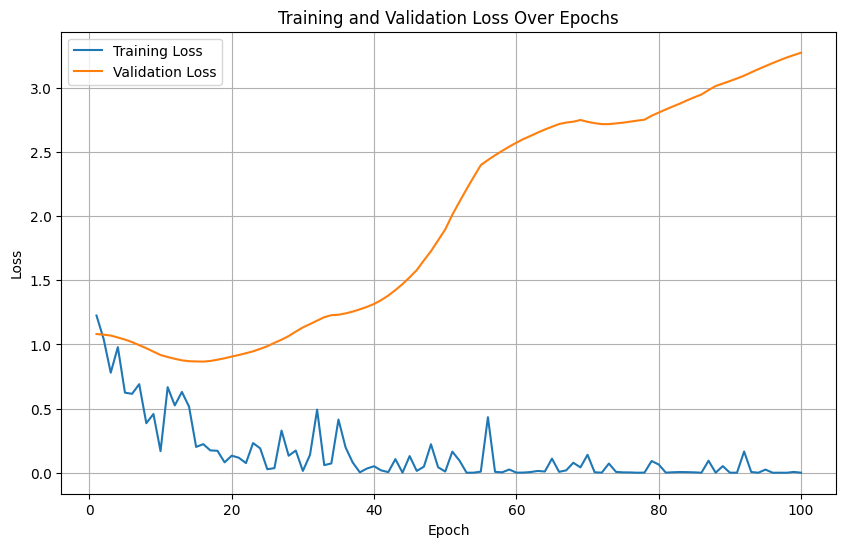

In [58]:
#검정할때는 모델을 고치면 안됨
#1. 기울기 계산할 필요가 없고, 가중치를 수정하지 않는다.
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset  # Subset 추가 필수!
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class TicTacToeCellDataset(Dataset):#파일 시스템에서 이미지와 JSON 라벨을 1:1로 매칭하여 파이토치 모델이 읽을 수 있는 텐서(Tensor) 형태로 변환
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = []
        self.labels_paths = []


        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

        for image_file in image_files:
            file_number = os.path.splitext(image_file)[0]
            label_filename = f"{file_number}_labels.json" # 파일명 규칙에 맞춰 생성
            label_path = os.path.join(label_dir, label_filename)

            if os.path.exists(label_path):
                self.image_paths.append(os.path.join(image_dir, image_file))
                self.labels_paths.append(label_path)

        print(f"✅ 매칭 성공: {len(self.image_paths)}개의 데이터를 찾았습니다!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 개별 이미지와 JSON 파일을 읽어옵니다.
        image = Image.open(self.image_paths[idx]).convert('RGB')
        with open(self.labels_paths[idx], 'r') as f:
            label_data = json.load(f)

        label_mapping = {'O': 0, 'X': 1, 'blank': 2}
        label_list = [label_mapping[label_data[f'cell_{i}']] for i in range(9)]
        label_tensor = torch.tensor(label_list, dtype=torch.long)

        if self.transform:
            image = self.transform(image)
        return image, label_tensor

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
])


dataset = TicTacToeCellDataset(
    image_dir='/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_test',    # 이미지 폴더 경로
    label_dir='//content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels_test', # 정답(라벨) 파일 경로
    transform=transform
)

# train, test split: 학습용과 검증용으로 데이터분석 :과적합 찾기
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset=Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TicTacToeCNN().to(device)  # 어제 정의한 모델 클래스
criterion = torch.nn.CrossEntropyLoss() # 분류 문제의 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 가중치 업데이트 도구

# 학습 루프:틱택토의 패턴을 가르치는단계
train_loss_history = []
val_loss_history = []
epochs = 100
# 1. train 단계

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()  # 1. 기울기(연습장) 초기화
        prediction = model(x).view(-1, 3) # 27개 출력을 3개씩 9칸으로!
        loss = criterion(prediction, y.view(-1)) # 정답과 매칭
        loss.backward()        # 4. 역전파 (기울기/수정계획 계산)
        optimizer.step()       # 5. 가중치 업데이트 (진짜 수정)

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)


    # 2. Validation 단계
    model.eval()  # 드롭아웃이나 배치정규화를사용해서
    # 여기에 코드 작성해주세요
    epoch_val_loss = 0
    with torch.no_grad(): # 기울기 계산을 완전히 꺼서 가중치 보호 및 메모리 절약
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)
            prediction = model(x).view(-1, 3)
            loss = criterion(prediction, y.view(-1))
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)

    # Print training and validation losses
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plotting training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

#train_loss_history vs val_loss_history: 두 지표를 동시에 그래프로 그려 모델이 언제 최적의 성능을 내는지, 혹은 언제부터 과적합이 발생하는지 추적


그래프 상으로 파란tortjs train은 0 에수렴ㅎ지만, 주황색선은 과적합을 보임,,,

현재 그래프를 보시면 Training Loss는 지속적으로 하락하여 모델이 학습 데이터에 완벽히 적응했음을 보여줍니다. 하지만 Validation Loss가 특정 시점 이후 다시 상승하는 과적합(Overfitting) 현상이 관찰되었습니다.

이는 학습 데이터셋의 규모가 작아(약 40개), 모델이 일반적인 특징을 추출하기보다 데이터를 암기했기 때문으로 분석됩니다. 이를 해결하기 위해 향후 **데이터 증강(Data Augmentation)**이나 드롭아웃(Dropout) 강화, 또는 Early Stopping 기법을 적용할 계획입니다."

"현재 그래프에서 Validation Loss가 다시 상승하는 구간이 발견되었는데, 이는 데이터 부족으로 인한 과적합 현상이며, 이를 통해 우리는 어느 시점에서 학습을 멈춰야(Early Stopping) 최상의 모델을 얻을 수 있는지를 판단할 수 있습니다."

In [59]:
import os

img_dir = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_black'
lbl_dir = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels'

print("이미지 폴더 파일 5개:", os.listdir(img_dir)[:5])
print("라벨 폴더 파일 5개:", os.listdir(lbl_dir)[:5])

이미지 폴더 파일 5개: ['17.jpg', '06.jpg', '09.jpg', '07.jpg', '02.jpg']
라벨 폴더 파일 5개: ['IMG_0722_labels.json', '16_labels.json', 'IMG_0726_labels.json', 'IMG_0727_labels.json', 'IMG_0719_labels.json']


# Test
- 해당 코드를 돌렸을 때 80% 이상의 정확도 나오게 만들기

✅ 매칭 성공: 3개의 데이터를 찾았습니다!


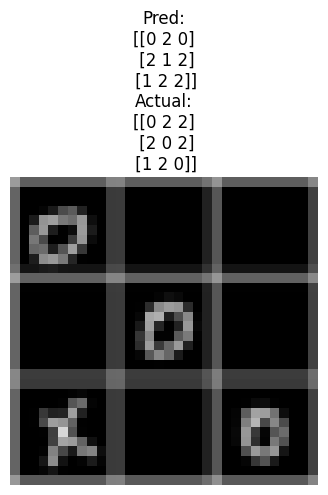

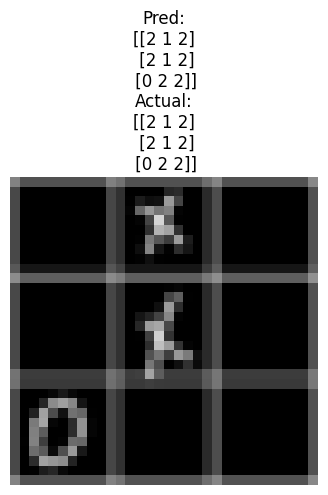

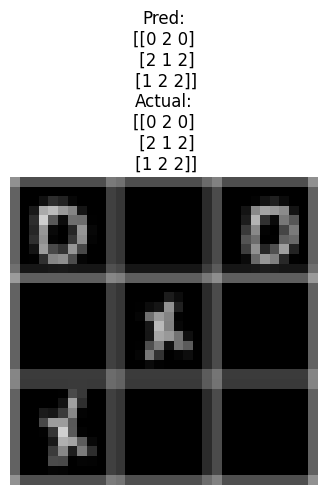

✅ 최종 테스트 정확도: 88.89%


In [60]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# 모델을 평가 모드로 전환
model.eval()

# 테스트 데이터셋을 위한 변환 설정 (이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# 1. 경로 설정 (아까 성공했던 그 경로를 그대로 넣으세요!)
TEST_IMAGE_DIR = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/image_test'
TEST_LABEL_DIR = '/content/drive/MyDrive/2026-1학부생인턴/3주차과제/labels_test'

# 2. 데이터 로더
test_dataset = TicTacToeCellDataset(image_dir=TEST_IMAGE_DIR, label_dir=TEST_LABEL_DIR, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 테스트 루프
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device) # 정답: [batch, 9]

        # 모델 예측: 결과 [batch, 27]
        outputs = model(inputs)

        # [핵심 수정] 27개를 (9칸, 3클래스)로 쪼개기 -> [batch, 9, 3]
        outputs = outputs.view(-1, 9, 3)

        # 각 셀별로 가장 높은 확률의 클래스 선택 -> [batch, 9]
        predicted = torch.argmax(outputs, dim=2)

        # 정확도 계산
        total += labels.numel()
        correct += (predicted == labels).sum().item()

        # 시각화를 위해 모양 변경
        predicted_grid = predicted.view(-1, 3, 3)
        labels_grid = labels.view(-1, 3, 3)

        # 샘플 시각화 (첫 번째 배치만)
        for i in range(inputs.size(0)):
            plt.figure(figsize=(4, 4))
            # 이미지 원복 (Tensor -> Numpy)
            img = inputs[i].cpu().numpy().transpose(1, 2, 0)
            plt.imshow(img)
            plt.title(f"Pred:\n{predicted_grid[i].cpu().numpy()}\nActual:\n{labels_grid[i].cpu().numpy()}")
            plt.axis("off")
            plt.show()

# 최종 정확도 출력
accuracy = 100 * correct / total
print(f"✅ 최종 테스트 정확도: {accuracy:.2f}%")
